<a href="https://colab.research.google.com/github/b62mp1/ExistingResults/blob/main/LSTM%20copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import *
from keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
df=pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

In [ ]:
# Check for missing values
def num_missing(x):
    return sum(x.isnull())

print("Missing values per column:")
print(df.apply(num_missing, axis=0))

print("\nMissing values per row:")
print(df.apply(num_missing, axis=1).head())

In [ ]:
def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Split the data into training and test datasets
split_index = 800
training_set = df.iloc[:split_index, 1:2].values
test_set = df.iloc[split_index:, 1:2].values

In [ ]:
# Normalizing and reshaping the training data

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, split_index):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
# Normalizing and reshaping the testing data
dataset_train = df.iloc[:split_index, 1:2]
dataset_test = df.iloc[split_index:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(dataset_total) - split_index + 60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

In [ ]:
# Building a moving average model
window = 20

# Create a moving average over the entire dataset
moving_avg = dataset_total.rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_index - window : dataset_total.index.max() - window + 1]

In [ ]:
# Building RNN model

# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(training_set_scaled, window_size, batch_size=128)

# Establish Model
model_rnn = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Add a 3rd dimension (feature dimensionality which in this case in univariate)
                      input_shape=[None]), # 1st dimension is batch size, input shape = None allows windows of any size to be used
  keras.layers.SimpleRNN(100, return_sequences=True), # takes in sequence (batch size, time, dimensionality per time step (univariate))
  keras.layers.SimpleRNN(100), # produces a single vector
  keras.layers.Dense(1), # produces 1 output 
])

# Early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50, restore_best_weights=True)

# Put model all together
model_rnn.compile(loss='mean_squared_error',optimizer='adam')
model_rnn.fit(train_set, epochs=100, batch_size=32)

In [ ]:
# Building LSTM model
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 9s 115ms/step - loss: 0.0338
Epoch 2/100
24/24 [==============================] - 3s 118ms/step - loss: 0.0092
Epoch 3/100
24/24 [==============================] - 3s 118ms/step - loss: 0.0075
Epoch 4/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0064
Epoch 5/100
24/24 [==============================] - 3s 120ms/step - loss: 0.0055
Epoch 6/100
24/24 [==============================] - 3s 114ms/step - loss: 0.0051
Epoch 7/100
24/24 [==============================] - 3s 118ms/step - loss: 0.0057
Epoch 8/100
24/24 [==============================] - 3s 114ms/step - loss: 0.0047
Epoch 9/100
24/24 [==============================] - 3s 118ms/step - loss: 0.0049
Epoch 10/100
24/24 [==============================] - 3s 117ms/step - loss: 0.0048
Epoch 11/100
24/24 [==============================] - 3s 121ms/step - loss: 0.0047
Epoch 12/100
24/24 [==============================] - 3s 118ms/step - loss: 0.0054
Epoch 13/100


In [ ]:
# Predicting the values
lstm_predicted_stock_price = model.predict(X_test)
lstm_predicted_stock_price = sc.inverse_transform(lstm_predicted_stock_price)
# All values normalized to training data
spy_normalized_to_traindata = sc.transform(dataset_total.values.reshape(-1, 1))
rnn_forecast = model_forecast(
    model_rnn,
    spy_normalized_to_traindata[split_index - window_size:-1],
    window_size)[:, 0]
rnn_predicted_stock_price = sc.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_predicted_stock_price.shape

(459,)

In [ ]:
# Method for plotting results
def plot_predictions(test, predicted_1, predicted_2, predicted_3, stock, total, index, dataframe):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,10))
    ax[0].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[0].plot(dataframe.loc[index:, 'Date'],predicted_1, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[0].legend(loc="upper left")
    ax[1].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[1].plot(dataframe.loc[index:, 'Date'],predicted_2, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[1].legend(loc="upper left")
    ax[2].plot(dataframe.loc[index:, 'Date'],test, color = 'red', label = 'Real ' + stock + ' Stock Price')
    ax[2].plot(dataframe.loc[index:, 'Date'],predicted_3, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
    ax[2].legend(loc="upper left")
    plt.xticks(np.arange(0, total - index, 50))
    plt.title(stock + ' Stock Price Prediction using Moving Average, RNN, LSTM respectively')
    plt.xlabel('Time')
    plt.ylabel(stock + 'Stock Price')
    plt.legend()
    plt.show()

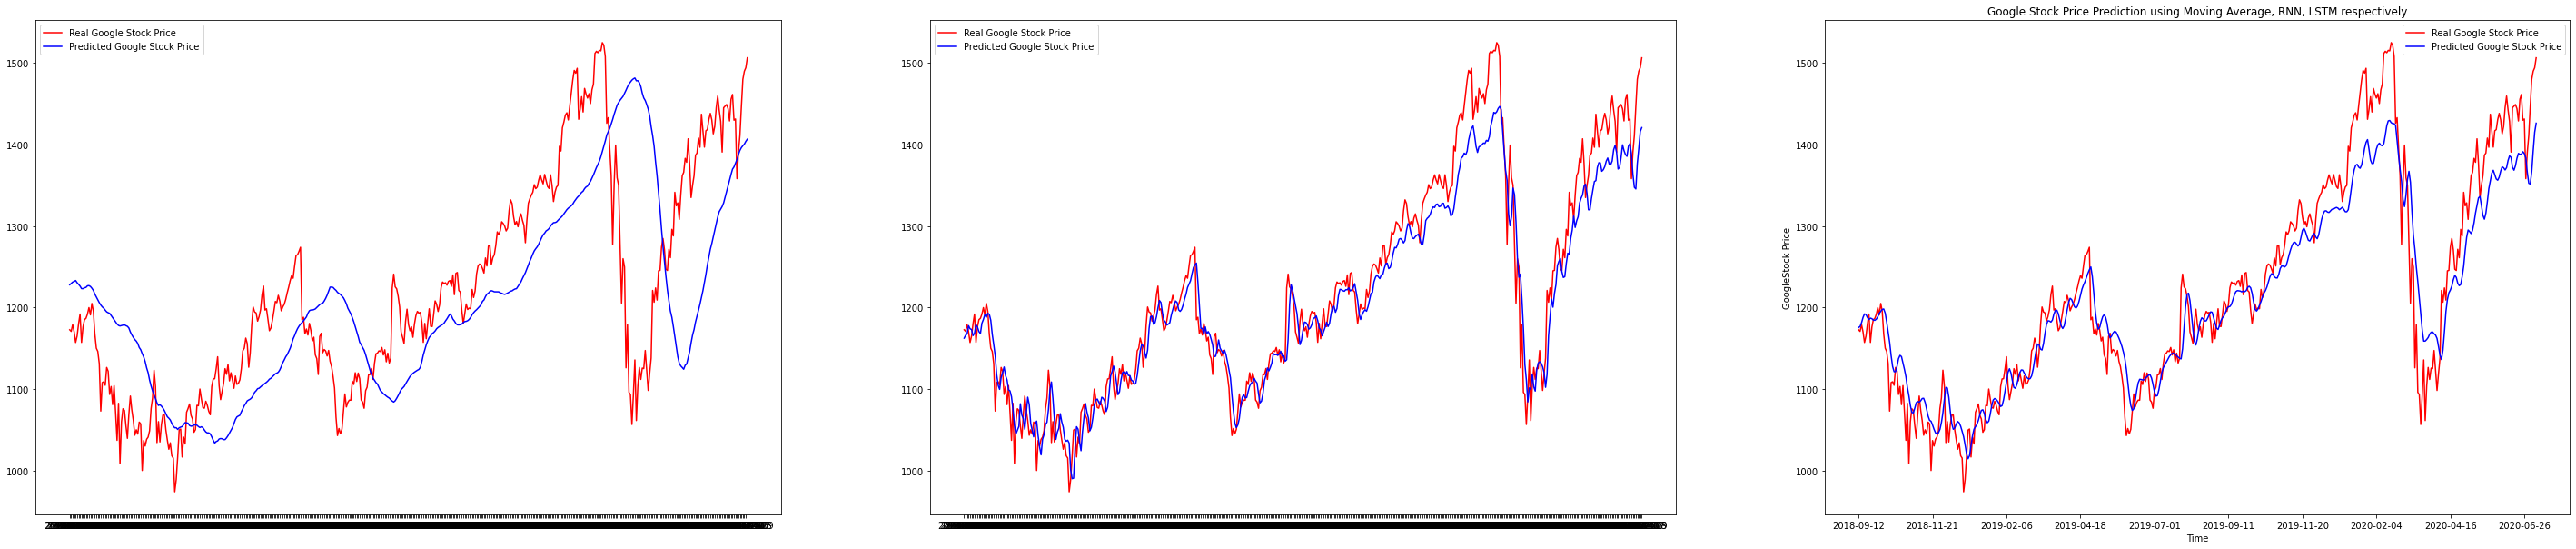

In [ ]:
# Visualising the results
plot_predictions(dataset_test.values, moving_avg_forecast, rnn_predicted_stock_price, lstm_predicted_stock_price, "Tesla", len(dataset_total), split_index, df)